In [1]:
%matplotlib inline

In [2]:
import numpy as np
import librosa
from librosa_ours import librosa as lib_ours
import matplotlib
import matplotlib.pyplot as plt
from scipy.io import wavfile

# for DTW
from scipy.spatial.distance import cdist
import six

//anaconda/lib/python3.5/site-packages/numba/errors.py:102: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [3]:
### define file names
fileOne = "audio_data/Chopin_Mazurka_Op30_No2_1_mono.wav"
fileTwo = "audio_data/Chopin_Mazurka_Op30_No2_2_mono.wav"

In [4]:
### read in the two wav files
freqOne, audioOne = wavfile.read(fileOne)
freqTwo, audioTwo = wavfile.read(fileTwo)
audioOne = audioOne.astype(float)
audioTwo = audioTwo.astype(float)

//anaconda/lib/python3.5/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


In [5]:
### generate chroma features from the audio data
hopLength = 4096 # 4096 * (1/44100 s/sample) = 9.3ms
nFFT = 32768 # 32768 * (1/44100 s/sample) = 74 ms
featuresOne = librosa.feature.chroma_stft(y = audioOne, sr = freqOne, hop_length = hopLength)
featuresTwo = librosa.feature.chroma_stft(y = audioTwo, sr = freqTwo, hop_length = hopLength)

In [90]:
### normalize the chroma features by their L2 norm in each column
featuresOne = librosa.util.normalize(featuresOne, norm=2, axis=0)
featuresTwo = librosa.util.normalize(featuresTwo, norm=2, axis=0)

In [7]:
###  setup DTW parameters
stepSizes = np.array([[1,1], [1, 2], [2, 1]])
weights = np.array([2, 3, 3])

In [8]:
### Run normal DTW
accumCostNormal, warpingPathNormal = lib_ours.sequence.dtw(featuresOne, featuresTwo, metric='cosine', step_sizes_sigma = stepSizes, weights_mul = weights, forward_update=False)

In [9]:
### Run our look-forward DTW
accumCostForward, warpingPathForward = lib_ours.sequence.dtw(featuresOne, featuresTwo, metric='cosine', step_sizes_sigma = stepSizes, weights_mul = weights, forward_update=True)

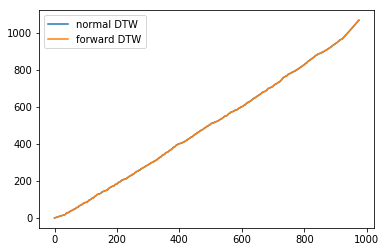

In [10]:
### Visualize both paths
plt.figure(0)
plt.plot([x for x, y in warpingPathNormal], [y for x, y in warpingPathNormal], label='normal DTW')
plt.plot([x for x, y in warpingPathForward], [y for x, y in warpingPathForward], label='forward DTW')
plt.legend()

In [11]:
### run subsequence DTW with each chunk, then plot in the correct location
def subsequenceDTWOnChunks(chunks):
    ###  setup DTW parameters
    stepSizes = np.array([1,1,1,2,2,1]).reshape((-1,2))
    weights = np.array([1,1,2])

    bestWarpingPaths = []
    accumCosts = [] # array of accumulated cost matrices
    warpingPaths = [] # array where each subarray contains the warping paths for a given chunk
    
    for chunkIndex in range(len(chunks)):
        accumCostChunk, bestWarpingPathChunk, stepMatrix = lib_ours.sequence.dtw(chunks[chunkIndex], featuresTwo, metric='cosine', step_sizes_sigma = stepSizes, weights_mul = weights, subseq=True, return_steps=True, forward_update=True)
        accumCosts.append(accumCostChunk)
        
        # adjust the best warping path to account for the chunk being in the middle of the piece
        adjustAmount = np.sum([x.shape[1] for x in chunks[:chunkIndex]])
        adjustedBestWarpingPath = [(row+adjustAmount,col) for (row,col) in bestWarpingPathChunk]
        bestWarpingPaths.append(adjustedBestWarpingPath)
        
        # find each of the warping paths for this chunk
        warpingPathsForChunk = []

        for lastFrameIndex in range(accumCosts[0].shape[1]):
            curWarpingPath = lib_ours.sequence.__dtw_backtracking(stepMatrix[:, :(lastFrameIndex+1)], stepSizes)
            adjustedCurWarpingPath = [(row+adjustAmount,col) for (row,col) in curWarpingPath]
            warpingPathsForChunk.append(adjustedCurWarpingPath)
        warpingPaths.append(warpingPathsForChunk)
        
            
    return bestWarpingPaths, accumCosts, warpingPaths

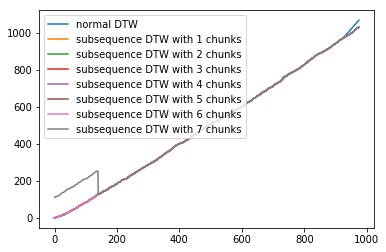

In [12]:
### split featuresOne into numChunks sub chunks
plt.figure(0)
plt.plot([x for x, y in warpingPathNormal], [y for x, y in warpingPathNormal], label='normal DTW')

for numChunks in range(1,8):
    plt.figure(0)
    chunks = np.array_split(featuresOne, numChunks, 1)
    bestWarpingPaths, accumCosts, warpingPaths = subsequenceDTWOnChunks(chunks)
    plt.plot([x for chunkPath in bestWarpingPaths[::-1] for x, y in chunkPath], [y for chunkPath in bestWarpingPaths[::-1] for x, y in chunkPath], label='subsequence DTW with {} chunks'.format(numChunks))
    plt.legend()
    
    '''
    # plot the warping paths for the first chunk
    plt.figure()
    for warpingPath in warpingPaths[-1]:
        plt.plot([x for x, y in warpingPath], [y for x, y in warpingPath])
    ''' 
    
plt.legend()

In [13]:
### run subsequence DTW on each chunk, get back all the needed warping paths, and the accumulated cost matrix
numChunks = 3
chunks = np.array_split(featuresOne, numChunks, 1)

bestWarpingPaths, accumCosts, warpingPaths = subsequenceDTWOnChunks(chunks)

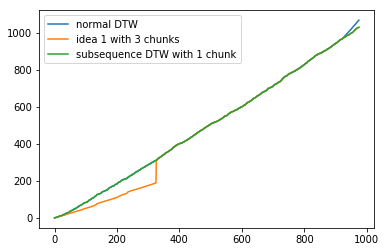

In [14]:
### Pull out the last frame from each subsequence cost matrix and put into a new matrix
lastCosts = np.zeros((len(accumCosts), accumCosts[0].shape[1]))

for chunkIndex in range(len(accumCosts)):
    lastCosts[chunkIndex,:] = accumCosts[chunkIndex][-1,:]
    
lastCosts[lastCosts==np.inf] = 9223372036854775807

stepSizes = np.array([1,0,0,1]).reshape((-1,2))
weights = np.array([1,0])

D, wp, stepMatrix = lib_ours.sequence.dtw(C=lastCosts, step_sizes_sigma = stepSizes, weights_mul = weights, subseq=True, return_steps=True)

backtrace = []
lastChunkIndex = wp[0][0] # the index of the last chunk
lastFrame = wp[0][1]

for elem in wp:
    # if the index changes, find the backtrace from this point
    if elem[0] != lastChunkIndex:
        backtrace.extend(warpingPaths[lastChunkIndex][lastFrame])
    lastChunkIndex = elem[0]
    lastFrame = elem[1]
    

# to add the backtrace for the first chunk
firstStepMatrix = stepMatrix[0,:]
firstStep = np.argwhere(firstStepMatrix!=-1)[0][0]
firstStep = firstStep - 1 # the real first step won't have a backtrace

backtrace.extend(warpingPaths[0][firstStep])

plt.figure(0)
plt.plot([x for x, y in warpingPathNormal], [y for x, y in warpingPathNormal], label='normal DTW')
plt.plot([x for x, y in backtrace], [y for x, y in backtrace], label='idea 1 with {} chunks'.format(numChunks))

# also plot subsequence with n = 1
chunks = np.array_split(featuresOne, 1, 1)
bestWarpingPaths, accumCosts, warpingPaths = subsequenceDTWOnChunks(chunks)
plt.plot([x for chunkPath in bestWarpingPaths[::-1] for x, y in chunkPath], [y for chunkPath in bestWarpingPaths[::-1] for x, y in chunkPath], label='subsequence DTW with 1 chunk')
    
plt.legend()

## Subsequence DTW Adjusted for Path Length

In [74]:
def __dtw_calc_accu_cost(C, D, D_steps, step_sizes_sigma,
                         weights_mul, weights_add, max_0, max_1, starting_points):  # pragma: no cover
    for cur_n in range(max_0, D.shape[0]):
        for cur_m in range(max_1, D.shape[1]):
            # accumulate costs
            for cur_step_idx, cur_w_add, cur_w_mul in zip(range(step_sizes_sigma.shape[0]),
                                                          weights_add, weights_mul):
                prev_n = cur_n - step_sizes_sigma[cur_step_idx, 0]
                prev_m = cur_m - step_sizes_sigma[cur_step_idx, 1]
                
                cur_D = D[prev_n, prev_m]
                cur_C = cur_w_mul * C[cur_n - max_0, cur_m - max_1]
                cur_C += cur_w_add
                cur_cost = cur_D + cur_C
                
                total_path_length = (cur_n - starting_points[prev_n,prev_m][0]) + (cur_m - starting_points[prev_n,prev_m][1])
                
                adjusted_cost = cur_cost/total_path_length
                
#                 print("cur row: ", cur_n, ", cur_col: ", cur_m, ", cur cost: ", cur_cost, ", total path length: ", total_path_length, ", adjusted cost: ", adjusted_cost, ", diff: ", cur_cost - adjusted_cost)

                # check if cur_cost is smaller than the one stored in D
                if adjusted_cost < (D[cur_n, cur_m] / total_path_length):
                    D[cur_n, cur_m] = cur_cost

                    # save step-index
                    D_steps[cur_n, cur_m] = cur_step_idx
                    
                    # save starting point
                    starting_points[cur_n, cur_m] = starting_points[prev_n, prev_m]

    return D, D_steps, starting_points


In [59]:
def __dtw_backtracking(D_steps, step_sizes_sigma):  # pragma: no cover

    wp = []
    # Set starting point D(N,M) and append it to the path
    cur_idx = (D_steps.shape[0] - 1, D_steps.shape[1] - 1)
    wp.append((cur_idx[0], cur_idx[1]))

    # Loop backwards.
    # Stop criteria:
    # Setting it to (0, 0) does not work for the subsequence dtw,
    # so we only ask to reach the first row of the matrix.
    while cur_idx[0] > 0:
        cur_step_idx = D_steps[(cur_idx[0], cur_idx[1])]

        # save tuple with minimal acc. cost in path
        cur_idx = (cur_idx[0] - step_sizes_sigma[cur_step_idx][0],
                   cur_idx[1] - step_sizes_sigma[cur_step_idx][1])

        # append to warping path
        wp.append((cur_idx[0], cur_idx[1]))

    return wp

In [82]:
def subsequence_dtw_adjusted(X=None, Y=None, C=None, metric='euclidean', step_sizes_sigma=None,
        weights_add=None, weights_mul=None, subseq=True, backtrack=True,
        global_constraints=False, band_rad=0.25, return_steps=False, forward_update=False):

    # Default Parameters
    if step_sizes_sigma is None:
        step_sizes_sigma = np.array([[1, 1], [0, 1], [1, 0]])
    if weights_add is None:
        weights_add = np.zeros(len(step_sizes_sigma))
    if weights_mul is None:
        weights_mul = np.ones(len(step_sizes_sigma))

    if len(step_sizes_sigma) != len(weights_add):
        raise ParameterError('len(weights_add) must be equal to len(step_sizes_sigma)')
    if len(step_sizes_sigma) != len(weights_mul):
        raise ParameterError('len(weights_mul) must be equal to len(step_sizes_sigma)')

    if C is None and (X is None or Y is None):
        raise ParameterError('If C is not supplied, both X and Y must be supplied')
    if C is not None and (X is not None or Y is not None):
        raise ParameterError('If C is supplied, both X and Y must not be supplied')

    transposed = False
    # calculate pair-wise distances, unless already supplied.
    if C is None:
        # take care of dimensions
        X = np.atleast_2d(X)
        Y = np.atleast_2d(Y)

        try:
            C = cdist(X.T, Y.T, metric=metric)
        except ValueError as e:
            msg = ('scipy.spatial.distance.cdist returned an error.\n'
                   'Please provide your input in the form X.shape=(K, N) and Y.shape=(K, M).\n'
                   '1-dimensional sequences should be reshaped to X.shape=(1, N) and Y.shape=(1, M).')
            six.reraise(ParameterError, ParameterError(msg))

        # for subsequence matching:
        # if N > M, Y can be a subsequence of X
        if subseq and (X.shape[1] > Y.shape[1]):
            transposed = True
            C = C.T

    C = np.atleast_2d(C)

    # if diagonal matching, Y has to be longer than X
    # (X simply cannot be contained in Y)
    if np.array_equal(step_sizes_sigma, np.array([[1, 1]])) and (C.shape[0] > C.shape[1]):
        raise ParameterError('For diagonal matching: Y.shape[1] >= X.shape[1] '
                             '(C.shape[1] >= C.shape[0])')

    max_0 = step_sizes_sigma[:, 0].max()
    max_1 = step_sizes_sigma[:, 1].max()

    if global_constraints:
        # Apply global constraints to the cost matrix
        fill_off_diagonal(C, band_rad, value=np.inf)

    # initialize whole matrix with infinity values
    D = np.ones(C.shape + np.array([max_0, max_1])) * np.inf
    
    # initialize starting point matrix with -1 values
    value = np.empty((), dtype=object)
    value[()] = (-1, -1)
    starting_points = np.full((C.shape + np.array([max_0, max_1])), value, dtype=object)
    
    # set first row starting points to point to themselves
    for i in range(starting_points.shape[1]):
        starting_points[max_0,i] = (0,i-max_0)
    
    # set starting point to C[0, 0]
    D[max_0, max_1] = C[0, 0]

    if subseq:
        D[max_0, max_1:] = C[0, :]

    # initialize step matrix with -1
    # will be filled in calc_accu_cost() with indices from step_sizes_sigma
    D_steps = -1 * np.ones(D.shape, dtype=np.int)

    # calculate accumulated cost matrix
    D, D_steps, starting_points = __dtw_calc_accu_cost(C, D, D_steps,
                                      step_sizes_sigma,
                                      weights_mul, weights_add,
                                      max_0, max_1, starting_points)
    
    print(starting_points)
    
    # delete infinity rows and columns
    D = D[max_0:, max_1:]
    D_steps = D_steps[max_0:, max_1:]
    starting_points = starting_points[max_0:, max_1:]

    if backtrack:
        if subseq:
            # search for global minimum in last row of D-matrix
            wp_end_idx = np.argmin(D[-1, :]) + 1
            wp = __dtw_backtracking(D_steps[:, :wp_end_idx], step_sizes_sigma)
        else:
            # perform warping path backtracking
            wp = __dtw_backtracking(D_steps, step_sizes_sigma)

        wp = np.asarray(wp, dtype=int)

        # since we transposed in the beginning, we have to adjust the index pairs back
        if C is None:
            if transposed:
                wp = np.fliplr(wp)

        if (return_steps):
            return D, wp, D_steps, starting_points
        else:
            return D, wp, starting_points
    else:
        if (return_steps):
            return D, D_steps, starting_points
        else:
            return D, starting_points

In [83]:
### Run our adjusted subsequence DTW
stepSizes = np.array([[1,1], [1, 2], [2, 1]])
weights = np.array([2, 3, 3])
small = featuresOne[:,0:50]
accumCostAdjusted, warpingPathAdjusted, _ = subsequence_dtw_adjusted(featuresOne, featuresTwo, metric='cosine', step_sizes_sigma = stepSizes, weights_mul = weights, subseq=True)

[[(-1, -1) (-1, -1) (-1, -1) ..., (-1, -1) (-1, -1) (-1, -1)]
 [(-1, -1) (-1, -1) (-1, -1) ..., (-1, -1) (-1, -1) (-1, -1)]
 [(0, -2) (0, -1) (0, 0) ..., (0, 1065) (0, 1066) (0, 1067)]
 ..., 
 [(-1, -1) (-1, -1) (-1, -1) ..., (0, 0) (0, 0) (0, 0)]
 [(-1, -1) (-1, -1) (-1, -1) ..., (0, 0) (0, 0) (0, 0)]
 [(-1, -1) (-1, -1) (-1, -1) ..., (0, 0) (0, 0) (0, 0)]]


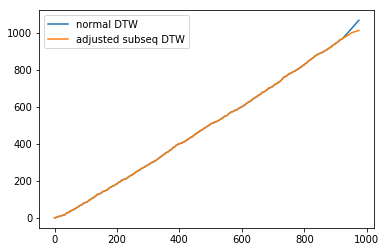

In [71]:
### Visualize both paths
plt.figure(0)
plt.plot([x for x, y in warpingPathNormal], [y for x, y in warpingPathNormal], label='normal DTW')
plt.plot([x for x, y in warpingPathAdjusted], [y for x, y in warpingPathAdjusted], label='adjusted subseq DTW')
plt.legend()

In [72]:
### run subsequence DTW with each chunk, then plot in the correct location
def adjustedSubsequenceDTWOnChunks(chunks):
    ###  setup DTW parameters
    stepSizes = np.array([1,1,1,2,2,1]).reshape((-1,2))
    weights = np.array([1,1,2])

    bestWarpingPaths = []
    accumCosts = [] # array of accumulated cost matrices
    warpingPaths = [] # array where each subarray contains the warping paths for a given chunk
    startingPoints = [] # array of starting points for each location in the cost matrices
    
    for chunkIndex in range(len(chunks)):
        accumCostChunk, bestWarpingPathChunk, stepMatrix, startingPointChunk = subsequence_dtw_adjusted(chunks[chunkIndex], featuresTwo, metric='cosine', step_sizes_sigma = stepSizes, weights_mul = weights, subseq=True, return_steps=True, forward_update=True)
        accumCosts.append(accumCostChunk)
        startingPoints.append(startingPointChunk)
        
        # adjust the best warping path to account for the chunk being in the middle of the piece
        adjustAmount = np.sum([x.shape[1] for x in chunks[:chunkIndex]])
        adjustedBestWarpingPath = [(row+adjustAmount,col) for (row,col) in bestWarpingPathChunk]
        bestWarpingPaths.append(adjustedBestWarpingPath)
        
        # find each of the warping paths for this chunk
        warpingPathsForChunk = []

        for lastFrameIndex in range(accumCosts[0].shape[1]):
            curWarpingPath = lib_ours.sequence.__dtw_backtracking(stepMatrix[:, :(lastFrameIndex+1)], stepSizes)
            adjustedCurWarpingPath = [(row+adjustAmount,col) for (row,col) in curWarpingPath]
            warpingPathsForChunk.append(adjustedCurWarpingPath)
        warpingPaths.append(warpingPathsForChunk)
        
            
    return bestWarpingPaths, accumCosts, warpingPaths, startingPoints

[[(-1, -1) (-1, -1) (-1, -1) ..., (-1, -1) (-1, -1) (-1, -1)]
 [(-1, -1) (-1, -1) (-1, -1) ..., (-1, -1) (-1, -1) (-1, -1)]
 [(2, 0) (2, 1) (2, 2) ..., (2, 1067) (2, 1068) (2, 1069)]
 ..., 
 [(-1, -1) (-1, -1) (-1, -1) ..., (2, 2) (2, 2) (2, 2)]
 [(-1, -1) (-1, -1) (-1, -1) ..., (2, 2) (2, 2) (2, 2)]
 [(-1, -1) (-1, -1) (-1, -1) ..., (2, 2) (2, 2) (2, 2)]]
[[(-1, -1) (-1, -1) (-1, -1) ..., (-1, -1) (-1, -1) (-1, -1)]
 [(-1, -1) (-1, -1) (-1, -1) ..., (-1, -1) (-1, -1) (-1, -1)]
 [(2, 0) (2, 1) (2, 2) ..., (2, 1067) (2, 1068) (2, 1069)]
 ..., 
 [(-1, -1) (-1, -1) (-1, -1) ..., (2, 2) (2, 2) (2, 2)]
 [(-1, -1) (-1, -1) (-1, -1) ..., (2, 2) (2, 2) (2, 2)]
 [(-1, -1) (-1, -1) (-1, -1) ..., (2, 2) (2, 2) (2, 2)]]
[[(-1, -1) (-1, -1) (-1, -1) ..., (-1, -1) (-1, -1) (-1, -1)]
 [(-1, -1) (-1, -1) (-1, -1) ..., (-1, -1) (-1, -1) (-1, -1)]
 [(2, 0) (2, 1) (2, 2) ..., (2, 1067) (2, 1068) (2, 1069)]
 ..., 
 [(-1, -1) (-1, -1) (-1, -1) ..., (2, 590) (2, 590) (2, 590)]
 [(-1, -1) (-1, -1) (-1, -1) .

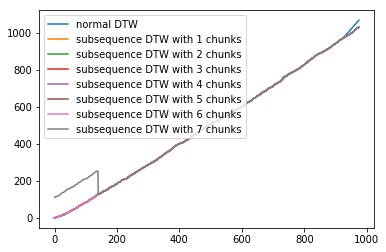

In [73]:
### split featuresOne into numChunks sub chunks
plt.figure(0)
plt.plot([x for x, y in warpingPathNormal], [y for x, y in warpingPathNormal], label='normal DTW')

for numChunks in range(1,8):
    plt.figure(0)
    chunks = np.array_split(featuresOne, numChunks, 1)
    bestWarpingPaths, accumCosts, warpingPaths, startingPoints = adjustedSubsequenceDTWOnChunks(chunks)
    plt.plot([x for chunkPath in bestWarpingPaths[::-1] for x, y in chunkPath], [y for chunkPath in bestWarpingPaths[::-1] for x, y in chunkPath], label='subsequence DTW with {} chunks'.format(numChunks))
    plt.legend()
    
plt.legend()

## Hierarchical

In [84]:
numChunks = 3
chunks = np.array_split(featuresOne, numChunks, 1)
bestWarpingPaths, accumCosts, warpingPaths, startingPoints = adjustedSubsequenceDTWOnChunks(chunks)

[[(-1, -1) (-1, -1) (-1, -1) ..., (-1, -1) (-1, -1) (-1, -1)]
 [(-1, -1) (-1, -1) (-1, -1) ..., (-1, -1) (-1, -1) (-1, -1)]
 [(0, -2) (0, -1) (0, 0) ..., (0, 1065) (0, 1066) (0, 1067)]
 ..., 
 [(-1, -1) (-1, -1) (-1, -1) ..., (0, 820) (0, 820) (0, 820)]
 [(-1, -1) (-1, -1) (-1, -1) ..., (0, 820) (0, 820) (0, 820)]
 [(-1, -1) (-1, -1) (-1, -1) ..., (0, 820) (0, 820) (0, 820)]]
[[(-1, -1) (-1, -1) (-1, -1) ..., (-1, -1) (-1, -1) (-1, -1)]
 [(-1, -1) (-1, -1) (-1, -1) ..., (-1, -1) (-1, -1) (-1, -1)]
 [(0, -2) (0, -1) (0, 0) ..., (0, 1065) (0, 1066) (0, 1067)]
 ..., 
 [(-1, -1) (-1, -1) (-1, -1) ..., (0, 813) (0, 813) (0, 813)]
 [(-1, -1) (-1, -1) (-1, -1) ..., (0, 813) (0, 813) (0, 813)]
 [(-1, -1) (-1, -1) (-1, -1) ..., (0, 813) (0, 813) (0, 813)]]
[[(-1, -1) (-1, -1) (-1, -1) ..., (-1, -1) (-1, -1) (-1, -1)]
 [(-1, -1) (-1, -1) (-1, -1) ..., (-1, -1) (-1, -1) (-1, -1)]
 [(0, -2) (0, -1) (0, 0) ..., (0, 1065) (0, 1066) (0, 1067)]
 ..., 
 [(-1, -1) (-1, -1) (-1, -1) ..., (0, 658) (0, 658

In [85]:
print(startingPoints)

[array([[(0, 0), (0, 1), (0, 2), ..., (0, 1065), (0, 1066), (0, 1067)],
       [(-1, -1), (0, 0), (0, 0), ..., (0, 1064), (0, 1064), (0, 1066)],
       [(-1, -1), (0, 0), (0, 0), ..., (0, 1064), (0, 1065), (0, 1066)],
       ..., 
       [(-1, -1), (-1, -1), (-1, -1), ..., (0, 820), (0, 820), (0, 820)],
       [(-1, -1), (-1, -1), (-1, -1), ..., (0, 820), (0, 820), (0, 820)],
       [(-1, -1), (-1, -1), (-1, -1), ..., (0, 820), (0, 820), (0, 820)]], dtype=object), array([[(0, 0), (0, 1), (0, 2), ..., (0, 1065), (0, 1066), (0, 1067)],
       [(-1, -1), (0, 0), (0, 1), ..., (0, 1064), (0, 1064), (0, 1066)],
       [(-1, -1), (0, 0), (0, 1), ..., (0, 1062), (0, 1062), (0, 1064)],
       ..., 
       [(-1, -1), (-1, -1), (-1, -1), ..., (0, 813), (0, 813), (0, 813)],
       [(-1, -1), (-1, -1), (-1, -1), ..., (0, 813), (0, 813), (0, 813)],
       [(-1, -1), (-1, -1), (-1, -1), ..., (0, 813), (0, 813), (0, 813)]], dtype=object), array([[(0, 0), (0, 1), (0, 2), ..., (0, 1065), (0, 1066), (0, 

In [93]:
### Pull out the last frame from each subsequence cost matrix and put into a new matrix
lastCosts = np.zeros((len(accumCosts), accumCosts[0].shape[1]))
lastStartingHeights = np.zeros((len(accumCosts), accumCosts[0].shape[1]))

# Normalize the cost array by the length of the path to that point
accumCostsNormalized = []
startingHeights = []

for chunkIndex in range(len(accumCosts)):
    accumCostChunkNormalized = np.zeros(accumCosts[chunkIndex].shape)
    startingHeightsChunk = np.zeros(accumCosts[chunkIndex].shape)
    
    for i in range(accumCosts[chunkIndex].shape[0]):
        for j in range(accumCosts[chunkIndex].shape[1]):
            length = i-startingPoints[chunkIndex][i, j][0] + j-startingPoints[chunkIndex][i, j][1]
            accumCostChunkNormalized[i, j] = accumCosts[chunkIndex][i, j] / length
            startingHeightsChunk[i,j] = startingPoints[chunkIndex][i, j][1]
    accumCostsNormalized.append(accumCostChunkNormalized)
    startingHeights.append(startingHeightsChunk)


for chunkIndex in range(len(accumCosts)):
    lastCosts[chunkIndex,:] = accumCostsNormalized[chunkIndex][-1,:]
    lastStartingHeights[chunkIndex,:] = startingHeights[chunkIndex][-1,:]
    
print(lastCosts)
print(lastStartingHeights)

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:16: RuntimeWarning: divide by zero encountered in double_scalars


[[        inf         inf         inf ...,  0.16528753  0.16493983
   0.1646208 ]
 [        inf         inf         inf ...,  0.10755308  0.10513529
   0.10189156]
 [        inf         inf         inf ...,  0.06429765  0.0645243
   0.06536335]]
[[  -1.   -1.   -1. ...,  820.  820.  820.]
 [  -1.   -1.   -1. ...,  813.  813.  813.]
 [  -1.   -1.   -1. ...,  658.  658.  658.]]


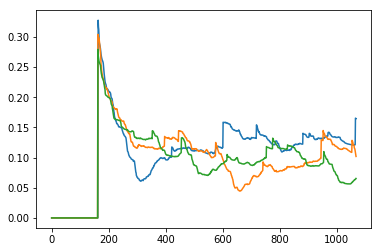

In [87]:
### visualize
lastCosts[lastCosts==np.inf]=0
plt.figure(0)
plt.plot(lastCosts[0])
plt.plot(lastCosts[1])
plt.plot(lastCosts[2])

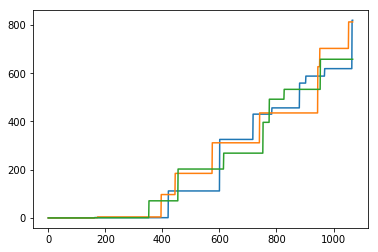

In [94]:
### visualize
plt.figure(0)
plt.plot(lastStartingHeights[0])
plt.plot(lastStartingHeights[1])
plt.plot(lastStartingHeights[2])

In [98]:
def preprocessHierarchicalDTW(hierarchicalDTWStartLocations, hierarchicalDTWCost):
    height = hierarchicalDTWStartLocations.shape[0]
    width = hierarchicalDTWStartLocations.shape[1]

    endOfNextPath = np.matrix(np.ones((height, width)) * np.inf)

    # Fill in the row index of the end of the first bridge we see
    # where the first bridge we see has a start height greater than the 
    # row we're at
    for col in range(width):
        savedEnd = -1
        savedStart = -1

        for row in range(height):
            # if we have a saved end value, fill that in
            if row < savedStart:
                endOfNextPath[row, col] = savedEnd
            else:
                # look through the hierarchical dtw start locations until we find the best next branch
                done = False
                endIndex = row+1

                while not done and endIndex < height:
                    currentStart = hierarchicalDTWStartLocations[endIndex][col]
                    currentCost = hierarchicalDTWCost[endIndex][col]
                    
                    if currentStart > row:
                        endOfNextPath[row, col] = endIndex

                        savedStart = currentStart
                        savedEnd = endIndex

                        done = True
                    endIndex += 1

    return endOfNextPath.astype(int)

In [99]:
endOfNextPath = preprocessHierarchicalDTW(lastStartingHeights, lastCosts)
print(endOfNextPath)

[[-9223372036854775808 -9223372036854775808 -9223372036854775808 ...,
                     1                    1                    1]
 [-9223372036854775808 -9223372036854775808 -9223372036854775808 ...,
                     1                    1                    1]
 [-9223372036854775808 -9223372036854775808 -9223372036854775808 ...,
                     1                    1                    1]]


In [ ]:
def hierarchicalDTW(hierarchicalCost, hierarchicalDTWStartLocations, endOfNextPath):
    '''
    We assume we have N strips, and a bootleg MIDI M pixels long

    hierarchicalCost: MxN np array. The last costs in each subsequence DTW accumulated cost matrix concatenated together
    hierarchicalDTWStartLocations: MxN np array. For location m, n it contains the start row of the path that ends at location m, n.
    endOfNextPath: MxN np array. For location m, n it contains the end row of the next path in strip n that starts strictly above location m (as if your previous path ended at m). 

    Returns:
    hierarchicalAccumulatedValue: our accumulated value matrix
    backtrace: an MxN np array of (int, int) tuples. 
    ''' 

    INT_INF = np.array([np.inf]).astype(int)[0] # get the int that np.inf is automatically cast to

    hierarchicalValue = -hierarchicalCost

    height = hierarchicalCost.shape[0]
    width = hierarchicalCost.shape[1]

    WEIGHT_FOR_NEXT_COL = 1.0
    # TEMPORARY make it impossible to jump to other cols
    #WEIGHT_FOR_OTHER_COLS = (1.0 - WEIGHT_FOR_NEXT_COL) / (width - 1)
    WEIGHT_FOR_OTHER_COLS = -np.inf

    # initialize an empty backtrace matrix
    value = np.empty((), dtype=object)
    value[()] = (-1, -1)
    hierarchicalBacktrace = np.full((height, width), value, dtype=object)

    # Initialize all value to be -inf
    accumHierarchicalValue = np.full((height, width), -np.inf)

    # initialize the first column
    # TEMPORARY: only allow us to start at (0,0)
    # accumHierarchicalValue[:, 0] = hierarchicalValue[:, 0]
    # so fill in only the rows which have a 0 start location
    for row in range(height):
        if hierarchicalDTWStartLocations[row, 0] == 0:
#             print("Filling row ", row)
            accumHierarchicalValue[row, 0] = hierarchicalValue[row, 0]

#     print("after first col: ", accumHierarchicalValue[:,0])

    # Consider jumps from every location (except in the last row)
    for row in range(height - 1):
#         print("Percent Done: ", round(100 * (float(row) / height), 1))
        for col in range(width):
            # update all locations that a path ending at this location can jump to.
            # for now we can't jump to our own column, so we remove it
            possibleCols = list(range(width))
            possibleCols.remove(col)
            for jumpCol in possibleCols:
                jumpRow = endOfNextPath[row, jumpCol]
                if (not jumpRow == INT_INF):
                    # weight transitioning to the next strip higher than jumping
                    curWeight = WEIGHT_FOR_NEXT_COL if (jumpCol == col + 1) else WEIGHT_FOR_OTHER_COLS
                    newValue = accumHierarchicalValue[row, col] + curWeight * hierarchicalValue[jumpRow, jumpCol]
                    # if we have found a higher value path to jumpRow, jumpCol then update our accumValue and backtrace
                    if (newValue > accumHierarchicalValue[jumpRow, jumpCol]):
                        # store the new value and the location you jumped from
                        accumHierarchicalValue[jumpRow, jumpCol] = newValue
                        hierarchicalBacktrace[jumpRow, jumpCol] = (row, col)

            # always consider the option to head directly upwards with 0 value added
            # TEMPORARY: for now ignore the option right upwards

            #if (accumHierarchicalValue[row, col] > accumHierarchicalValue[row + 1, col]):
                #accumHierarchicalValue[row + 1, col] = accumHierarchicalValue[row, col]
                #hierarchicalBacktrace[row + 1, col] = (row, col)

    return accumHierarchicalValue, hierarchicalBacktrace